# Stress Test 01: Random Rotations

The idea of this script is to perform a stress test on autoencoders. We wish to see what happens to the autoencoder's output when the input is distorted. For a given image, we first randomly rotate that image by 0, 90, 180 or 270 degrees. Now, this randomly rotated image is given as input to autoencoder, and its task is to reconstruct the original unrotated image. This can work if the autoencoder learns concepts that are invariant to rotation.


In [16]:
import os
import torch
import hashlib
import torchvision
from torchview import draw_graph
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA    # Foe visualization of latent space
from torch.utils.data import DataLoader, random_split

In [17]:
# Generating a personalized random seed
username = "prit.kanadiya"
seed = int(hashlib.sha256(username.encode()).hexdigest(), 16) % (2**32)
print(seed)
np.random.seed(seed)
generator = torch.Generator().manual_seed(seed)

1379217023


In [18]:
# Import Fashion MNIST train and test data
transform = torchvision.transforms.ToTensor()

train_data = torchvision.datasets.FashionMNIST(root = "./fashion-mnist-data", train = True, download = True, transform = transform)
test_data = torchvision.datasets.FashionMNIST(root = "./fashion-mnist-data", train = False, download = True, transform = transform)

In [19]:
print(train_data[0][0].shape)
print(test_data[0][0].shape)

# Using 10% of train data as val data
train_size = int(0.9 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size], generator=generator)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
Training samples: 54000
Validation samples: 6000
Test samples: 10000


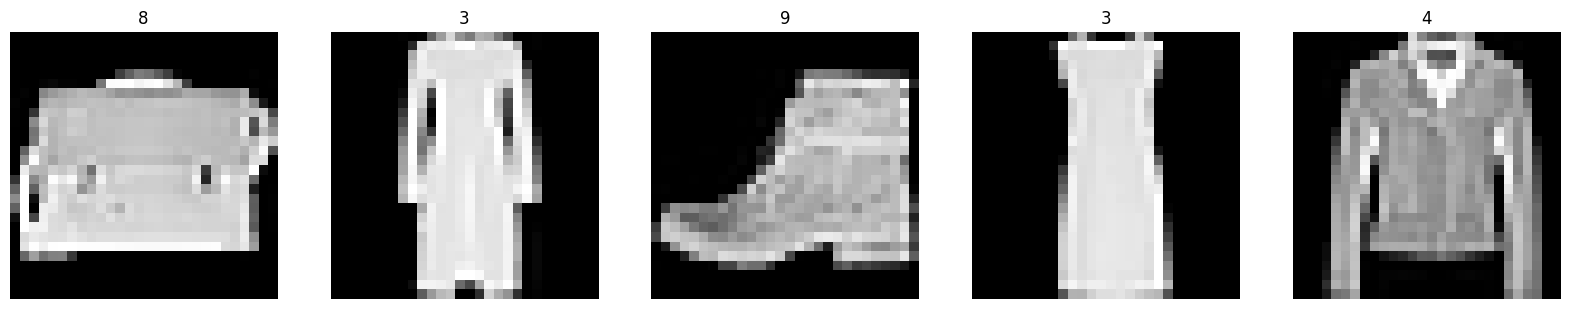

In [20]:
# Visualizing a few samples
# T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, and Ankle boot
num_samples = 5
fig, axes = plt.subplots(1, num_samples, figsize=(20, 5)) 

for i in range(num_samples):
    img, label = train_data[i]
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(str(label))
    axes[i].axis('off')

plt.show()


In [21]:
# Creating dataloaders out of the train and validation data
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [22]:
# Defining Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, num_filters, bottleneck_size):
        super().__init__()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # Encoder side of the model
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = num_filters,  kernel_size = 3, padding = 1)    # in_channels will always be one since image is grayscale
        self.enc_batch_norm1 = nn.BatchNorm2d(num_features = num_filters)
        self.enc_max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)    # (28, 28, num_filters) -> (14, 14, num_filters*2)

        self.conv2 = nn.Conv2d(in_channels = num_filters, out_channels = num_filters*4,  kernel_size = 3, padding = 1)    
        self.enc_batch_norm2 = nn.BatchNorm2d(num_features = num_filters*4)
        self.enc_max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)    # (14, 14, num_filter*2) -> (7, 7, num_filters*4)

        self.enc_fcnn = nn.Linear(7*7*4*num_filters, bottleneck_size)

        # Decoder side of the model
        self.dec_fcnn = nn.Linear(bottleneck_size, 7*7*4*num_filters)

        self.deconv2 = nn.ConvTranspose2d(in_channels = num_filters*4, out_channels = num_filters*2, kernel_size = 3, stride = 2, padding = 1, output_padding=1)
        self.dec_batch_norm2 = nn.BatchNorm2d(num_features = 2*num_filters)     # (7, 7, num_filters*4) -> (14, 14, num_filter*2)

        self.deconv1 = nn.ConvTranspose2d(in_channels = num_filters*2, out_channels = num_filters, kernel_size = 3, stride = 2, padding = 1, output_padding=1)
        self.dec_batch_norm1 = nn.BatchNorm2d(num_features = num_filters)    # (14, 14, num_filters*2) -> (28, 28, num_filters)

        self.deconv_out = nn.Conv2d(in_channels=num_filters, out_channels=1, kernel_size=3, padding=1)    # (28, 28, num_filters) -> (28, 28, 1)
    
    def forward(self, x, inference=False):

        if (inference == True):
            latent = x
        else:
            # Encoder phase
            x = self.conv1(x)
            x = self.enc_batch_norm1(x)
            x = self.relu(x)
            x = self.enc_max_pool1(x)    # (28, 28, num_filters) -> (14, 14, num_filters*2)

            x = self.conv2(x)
            x = self.enc_batch_norm2(x)
            x = self.relu(x)
            x = self.enc_max_pool2(x)    # (14, 14, num_filter*2) -> (7, 7, num_filters*4)

            x = x.view(x.size(0), -1)    # (7, 7, num_filters*4) -> (7*7*num_filters*4, 1)

            latent = self.enc_fcnn(x)    # This is the latent space of dimension bottleneck_size
            
        x = self.dec_fcnn(latent)    # This goes from latent space to vector back

        x = x.view(x.size(0), -1, 7, 7)    # (7*7*num_filters*4, 1) -> (7, 7, num_filters*4)

        x = self.deconv2(x)
        x = self.dec_batch_norm2(x)    # (7, 7, num_filters*4) -> (14, 14, num_filters*2)

        x = self.deconv1(x)
        x = self.dec_batch_norm1(x)    # (14, 14, num_filters*2) -> (28, 28, num_filters)

        x = self.deconv_out(x)    # (28, 28, num_filters) -> (28, 28, 1)
        x = self.sigmoid(x)    # This is done to ensure the output lies in (0, 1) range

        return x, latent


In [23]:
# # For visualizing model, we will define sample parameters
# num_filters = 8
# bottleneck_size = 2
# model = Autoencoder(num_filters=num_filters, bottleneck_size=bottleneck_size)

# dummy_input = torch.randn(1, 1, 28, 28)  # batch_size=1, channels=1, height=28, width=28
# graph = draw_graph(model, input_data=dummy_input)

# graph.visual_graph.render('logs/autoencoder_architecture_graph', format='png', cleanup=True)    # This requires some configurations on windows

In [24]:
def train_one_epoch(autoencoder, train_loader, val_loader, optimizer, loss_function):
    autoencoder.train()

    autoencoder.train()
    for img, label in tqdm(train_loader, desc="training"):
        optimizer.zero_grad()

        # Rotating randomly by 0, 90, 180 or 270 degrees
        k = torch.randint(0, 4, (1,)).item()    
        rotated_img = torch.rot90(img, k, dims=[2, 3])
        reconstructed_img, latent = autoencoder(rotated_img)
        loss = loss_function(reconstructed_img, img)
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        autoencoder.eval()
        for img, label in tqdm(val_loader, desc="Validating"):
            k = torch.randint(0, 4, (1,)).item()
            rotated_img = torch.rot90(img, k, dims=[2, 3])
            reconstructed_img, latent = autoencoder(rotated_img)
            val_loss = loss_function(reconstructed_img, img)

    print(f"Training loss: {loss} | Validation loss: {val_loss}")

    return loss.item(), val_loss.item()


In [25]:
def train(autoencoder, train_loader, val_loader, optimizer, loss_function, num_epochs):
    train_losses = []
    val_losses = []
    best_val_loss = float("inf")

    if not os.path.exists("./logs"):
        os.makedirs("./logs")
    
    if not os.path.exists("./checkpoints"):
        os.makedirs("./checkpoints")

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}", flush=True)
        train_loss, val_loss = train_one_epoch(autoencoder, train_loader, val_loader, optimizer, loss_function)

        # Visualizing reconstructions after each epoch
        num_samples = 10
        fig, axes = plt.subplots(3, num_samples, figsize=(20, 10)) 

        for i in range(num_samples):
            img, label = val_data[i]
            img = img.unsqueeze(0)    # Adding a batch dimension

            k = torch.randint(0, 4, (1,)).item()
            rotated_img = torch.rot90(img, k, dims=[2, 3])            
            reconstructed_img, latent = autoencoder(rotated_img)

            axes[0, i].imshow(img.squeeze(), cmap='gray')
            axes[0, i].set_title(f"original")
            axes[0, i].axis('off')

            axes[1, i].imshow(rotated_img.squeeze().detach().cpu().numpy(), cmap='gray')
            axes[1, i].set_title(f"input k={k}")
            axes[1, i].axis('off')

            axes[2, i].imshow(reconstructed_img.squeeze().detach().cpu().numpy(), cmap='gray')
            axes[2, i].set_title(f"reconstructed")
            axes[2, i].axis('off')

        plt.savefig(f"logs/reconstructed_samples_epoch_{epoch + 1}.png")
        plt.close(fig)

        # Saving the model if val loss improves
        if (val_loss < best_val_loss):
            checkpoint = {
            'epoch': epoch,
            'model_state_dict': autoencoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }
            torch.save(checkpoint, f'checkpoints/autoencoder_checkpoint_epoch_best.pth')
            print(f"Saved checkpoints at logs/checkpoints/autoencoder_checkpoint_best.pth")

        print(f"Saved reconstucted plots at logs/reconstructed_samples_epoch_{epoch + 1}.png")
        print()

        train_losses.append(train_loss)
        val_losses.append(val_loss)

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig("logs/loss_curve.png")
    print(f"Saved loss curves at logs/loss_curve.png")
    plt.show()
    plt.close()


In [26]:
num_filters = 16
bottleneck_size = 128
num_epochs = 20

# Defining model, optimizer and loss
device = "cuda" if torch.cuda.is_available() else "cpu"
autoencoder = Autoencoder(num_filters, bottleneck_size)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 1e-4)
loss_function = nn.MSELoss()

print(f"Using device: {device}")

Using device: cpu


Epoch 1/20


Validating: 100%|██████████| 47/47 [00:07<00:00,  6.51it/s]


Training loss: 0.03998955339193344 | Validation loss: 0.0438578836619854
Saved checkpoints at logs/checkpoints/autoencoder_checkpoint_best.pth
Saved reconstucted plots at logs/reconstructed_samples_epoch_1.png

Epoch 2/20


Validating: 100%|██████████| 47/47 [00:07<00:00,  5.99it/s]


Training loss: 0.0297861285507679 | Validation loss: 0.037395935505628586
Saved checkpoints at logs/checkpoints/autoencoder_checkpoint_best.pth
Saved reconstucted plots at logs/reconstructed_samples_epoch_2.png

Epoch 3/20


Validating: 100%|██████████| 47/47 [00:02<00:00, 16.69it/s]


Training loss: 0.030609315261244774 | Validation loss: 0.02662031352519989
Saved checkpoints at logs/checkpoints/autoencoder_checkpoint_best.pth
Saved reconstucted plots at logs/reconstructed_samples_epoch_3.png

Epoch 4/20


Validating: 100%|██████████| 47/47 [00:05<00:00,  9.28it/s]


Training loss: 0.02621295303106308 | Validation loss: 0.026612214744091034
Saved checkpoints at logs/checkpoints/autoencoder_checkpoint_best.pth
Saved reconstucted plots at logs/reconstructed_samples_epoch_4.png

Epoch 5/20


Validating: 100%|██████████| 47/47 [00:04<00:00,  9.40it/s]


Training loss: 0.021667473018169403 | Validation loss: 0.023410340771079063
Saved checkpoints at logs/checkpoints/autoencoder_checkpoint_best.pth
Saved reconstucted plots at logs/reconstructed_samples_epoch_5.png

Epoch 6/20


Validating: 100%|██████████| 47/47 [00:02<00:00, 15.78it/s]


Training loss: 0.027517233043909073 | Validation loss: 0.023733986541628838
Saved checkpoints at logs/checkpoints/autoencoder_checkpoint_best.pth
Saved reconstucted plots at logs/reconstructed_samples_epoch_6.png

Epoch 7/20


Validating: 100%|██████████| 47/47 [00:02<00:00, 16.17it/s]


Training loss: 0.02251213602721691 | Validation loss: 0.02531152218580246
Saved checkpoints at logs/checkpoints/autoencoder_checkpoint_best.pth
Saved reconstucted plots at logs/reconstructed_samples_epoch_7.png

Epoch 8/20


Validating: 100%|██████████| 47/47 [00:02<00:00, 15.92it/s]


Training loss: 0.020358288660645485 | Validation loss: 0.04102902486920357
Saved checkpoints at logs/checkpoints/autoencoder_checkpoint_best.pth
Saved reconstucted plots at logs/reconstructed_samples_epoch_8.png

Epoch 9/20


Validating: 100%|██████████| 47/47 [00:02<00:00, 16.47it/s]


Training loss: 0.02093459852039814 | Validation loss: 0.023937705904245377
Saved checkpoints at logs/checkpoints/autoencoder_checkpoint_best.pth
Saved reconstucted plots at logs/reconstructed_samples_epoch_9.png

Epoch 10/20


Validating: 100%|██████████| 47/47 [00:03<00:00, 14.69it/s]


Training loss: 0.023912327364087105 | Validation loss: 0.029161853715777397
Saved checkpoints at logs/checkpoints/autoencoder_checkpoint_best.pth
Saved reconstucted plots at logs/reconstructed_samples_epoch_10.png

Epoch 11/20


Validating: 100%|██████████| 47/47 [00:06<00:00,  7.15it/s]


Training loss: 0.01999622955918312 | Validation loss: 0.029782412573695183
Saved checkpoints at logs/checkpoints/autoencoder_checkpoint_best.pth
Saved reconstucted plots at logs/reconstructed_samples_epoch_11.png

Epoch 12/20


Validating: 100%|██████████| 47/47 [00:04<00:00, 11.43it/s]


Training loss: 0.018178854137659073 | Validation loss: 0.040077682584524155
Saved checkpoints at logs/checkpoints/autoencoder_checkpoint_best.pth
Saved reconstucted plots at logs/reconstructed_samples_epoch_12.png

Epoch 13/20


Validating: 100%|██████████| 47/47 [00:03<00:00, 14.07it/s]


Training loss: 0.017175450921058655 | Validation loss: 0.032172322273254395
Saved checkpoints at logs/checkpoints/autoencoder_checkpoint_best.pth
Saved reconstucted plots at logs/reconstructed_samples_epoch_13.png

Epoch 14/20


Validating: 100%|██████████| 47/47 [00:02<00:00, 16.49it/s]


Training loss: 0.01778658851981163 | Validation loss: 0.023230180144309998
Saved checkpoints at logs/checkpoints/autoencoder_checkpoint_best.pth
Saved reconstucted plots at logs/reconstructed_samples_epoch_14.png

Epoch 15/20


Validating: 100%|██████████| 47/47 [00:03<00:00, 15.50it/s]


Training loss: 0.018400078639388084 | Validation loss: 0.02922687865793705
Saved checkpoints at logs/checkpoints/autoencoder_checkpoint_best.pth
Saved reconstucted plots at logs/reconstructed_samples_epoch_15.png

Epoch 16/20


Validating: 100%|██████████| 47/47 [00:03<00:00, 15.17it/s]


Training loss: 0.019032781943678856 | Validation loss: 0.032004497945308685
Saved checkpoints at logs/checkpoints/autoencoder_checkpoint_best.pth
Saved reconstucted plots at logs/reconstructed_samples_epoch_16.png

Epoch 17/20


Validating: 100%|██████████| 47/47 [00:03<00:00, 13.47it/s]


Training loss: 0.01806982420384884 | Validation loss: 0.03094368614256382
Saved checkpoints at logs/checkpoints/autoencoder_checkpoint_best.pth
Saved reconstucted plots at logs/reconstructed_samples_epoch_17.png

Epoch 18/20


Validating: 100%|██████████| 47/47 [00:02<00:00, 15.93it/s]


Training loss: 0.016065314412117004 | Validation loss: 0.02122853696346283
Saved checkpoints at logs/checkpoints/autoencoder_checkpoint_best.pth
Saved reconstucted plots at logs/reconstructed_samples_epoch_18.png

Epoch 19/20


Validating: 100%|██████████| 47/47 [00:03<00:00, 15.60it/s]


Training loss: 0.01759105734527111 | Validation loss: 0.0316842645406723
Saved checkpoints at logs/checkpoints/autoencoder_checkpoint_best.pth
Saved reconstucted plots at logs/reconstructed_samples_epoch_19.png

Epoch 20/20


Validating: 100%|██████████| 47/47 [00:03<00:00, 14.08it/s]


Training loss: 0.01602681167423725 | Validation loss: 0.03285103663802147
Saved checkpoints at logs/checkpoints/autoencoder_checkpoint_best.pth
Saved reconstucted plots at logs/reconstructed_samples_epoch_20.png

Saved loss curves at logs/loss_curve.png


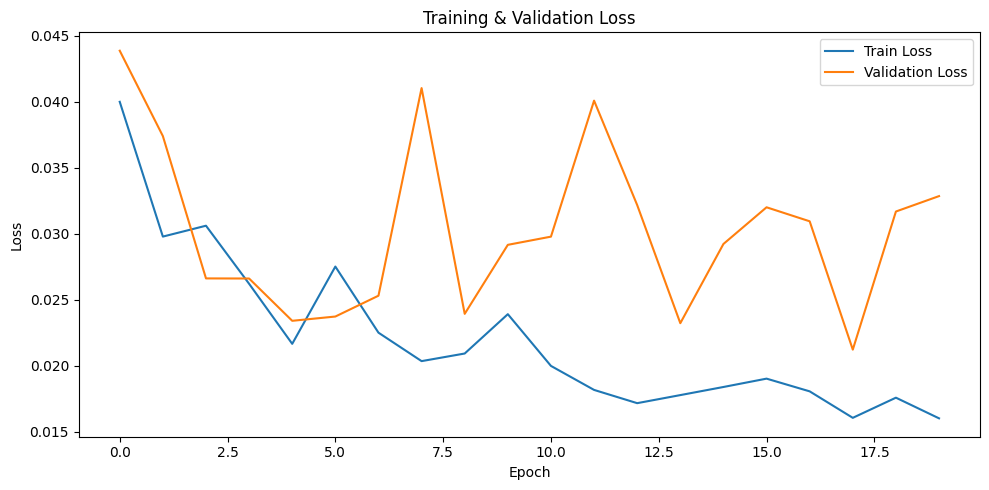

In [27]:
train(autoencoder, train_loader, val_loader, optimizer, loss_function, num_epochs)

In [28]:
# Loading the best checkpoint
checkpoint = torch.load("checkpoints/autoencoder_checkpoint_epoch_best.pth", map_location=device)
autoencoder.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

Validating: 100%|██████████| 47/47 [00:03<00:00, 14.40it/s]


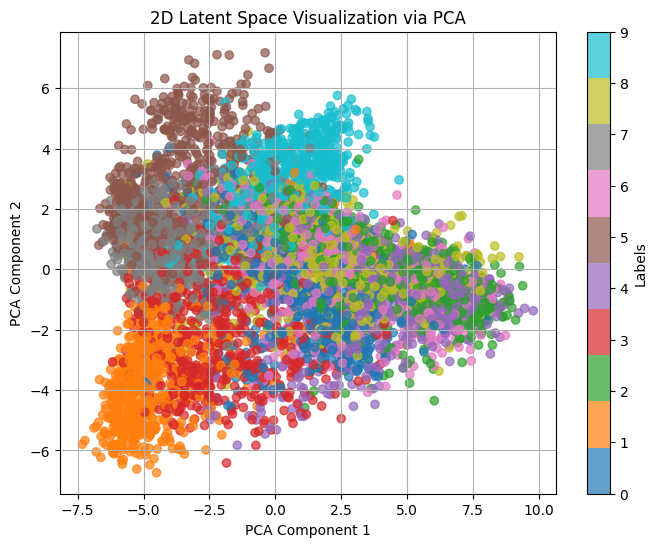

In [29]:
# Choosing top 2 dimensions according to PCA for visualizing the latent space
all_latents = []
all_labels = []

autoencoder.eval()
with torch.no_grad():
    for img, label in tqdm(val_loader, desc="Validating"):
        reconstructed_img, latent = autoencoder(img)
        latent = latent.view(latent.size(0), -1)  
        all_latents.append(latent)
        all_labels.append(label)

all_latents = torch.cat(all_latents, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

# Apply PCA to reduce to 2D dimension
pca = PCA(n_components=2)
latents_2d = pca.fit_transform(all_latents)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=all_labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D Latent Space Visualization via PCA')
plt.grid(True)
plt.savefig("logs/latent_space_visualization.png")
plt.show()
plt.close()

In [30]:
# Grouping all the latent vectors to obtain their mean
latent_dict = {i: [] for i in range(10)}

for i in range(len(all_latents)):
    latent_dict[all_labels[i]].append(all_latents[i])

mean_dict = {}
for i in range(10):
    mean_dict[i] = sum(latent_dict[i]) / len(latent_dict[i])

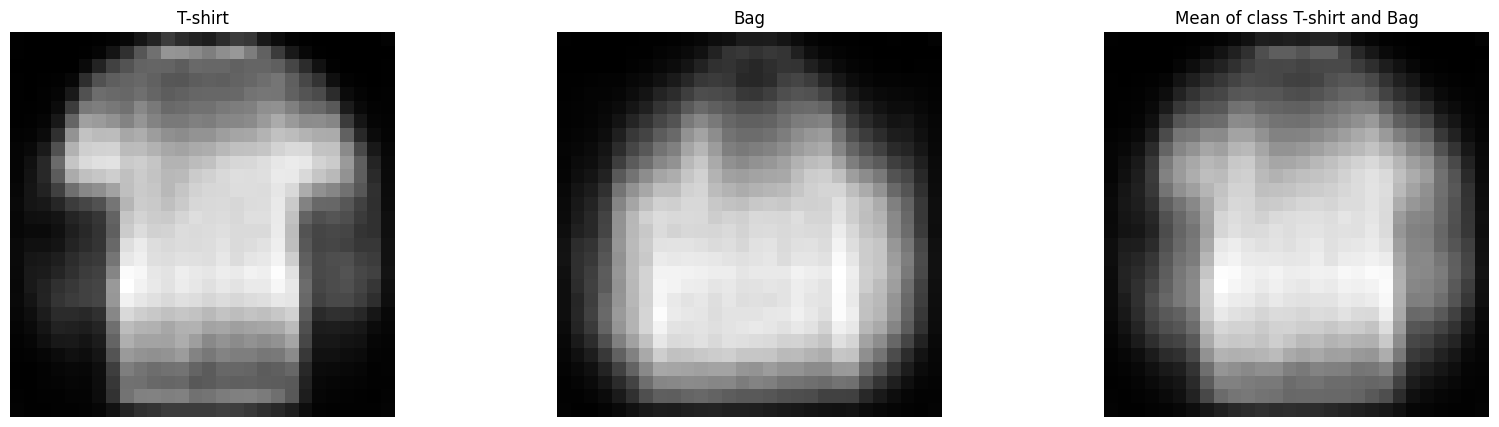

In [31]:
class0 = 0
class1 = 8

class_mapping = {
    0: "T-shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

query = (mean_dict[class0] + mean_dict[class1]) / 2
query = torch.tensor(query)
query = query.unsqueeze(0)
x0 = torch.tensor(mean_dict[class0]).unsqueeze(0)
x1 = torch.tensor(mean_dict[class1]).unsqueeze(0)

fig, axes = plt.subplots(1, 3, figsize=(20, 5)) 

# Observing image from class0
reconstructed_img, latent = autoencoder(x0, inference=True)
axes[0].imshow(reconstructed_img.squeeze().detach().numpy(), cmap='gray')
axes[0].set_title(f"{class_mapping[class0]}")
axes[0].axis('off')

# Observing image from class1
reconstructed_img, latent = autoencoder(x1, inference=True)
axes[1].imshow(reconstructed_img.squeeze().detach().numpy(), cmap='gray')
axes[1].set_title(f"{class_mapping[class1]}")
axes[1].axis('off')

# Observing the reconstructed image
reconstructed_img, latent = autoencoder(query, inference=True)
axes[2].imshow(reconstructed_img.squeeze().detach().numpy(), cmap='gray')
axes[2].set_title(f"Mean of class {class_mapping[class0]} and {class_mapping[class1]}")
axes[2].axis('off')

plt.savefig(f"logs/reconstruction_from_{class_mapping[class0]}_{class_mapping[class1]}.png")
plt.show()
plt.close()

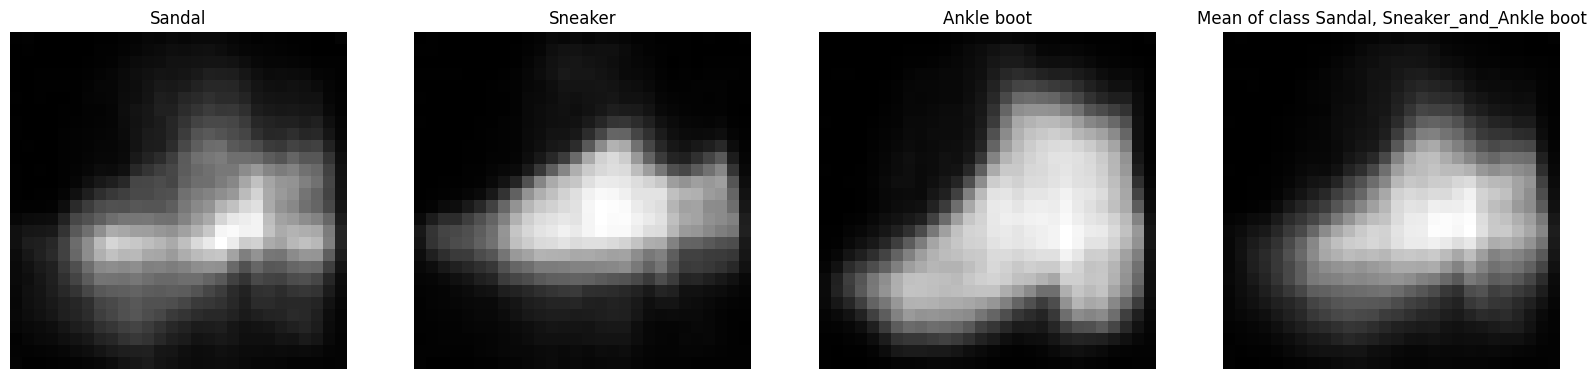

In [32]:
# Trying to find the combination of 3 classes
class0 = 5
class1 = 7
class2 = 9

query = (mean_dict[class0] + mean_dict[class1] + mean_dict[class2]) / 3
query = torch.tensor(query)
query = query.unsqueeze(0)
x0 = torch.tensor(mean_dict[class0]).unsqueeze(0)
x1 = torch.tensor(mean_dict[class1]).unsqueeze(0)
x2 = torch.tensor(mean_dict[class2]).unsqueeze(0)

fig, axes = plt.subplots(1, 4, figsize=(20, 5)) 

# Observing image from class0
reconstructed_img, latent = autoencoder(x0, inference=True)
axes[0].imshow(reconstructed_img.squeeze().detach().numpy(), cmap='gray')
axes[0].set_title(f"{class_mapping[class0]}")
axes[0].axis('off')

# Observing image from class1
reconstructed_img, latent = autoencoder(x1, inference=True)
axes[1].imshow(reconstructed_img.squeeze().detach().numpy(), cmap='gray')
axes[1].set_title(f"{class_mapping[class1]}")
axes[1].axis('off')

# Observing image from class1
reconstructed_img, latent = autoencoder(x2, inference=True)
axes[2].imshow(reconstructed_img.squeeze().detach().numpy(), cmap='gray')
axes[2].set_title(f"{class_mapping[class2]}")
axes[2].axis('off')

# Observing the reconstructed image
reconstructed_img, latent = autoencoder(query, inference=True)
axes[3].imshow(reconstructed_img.squeeze().detach().numpy(), cmap='gray')
axes[3].set_title(f"Mean of class {class_mapping[class0]}, {class_mapping[class1]}_and_{class_mapping[class2]}")
axes[3].axis('off')

plt.savefig(f"logs/reconstruction_from_{class_mapping[class0]}_{class_mapping[class1]}_{class_mapping[class2]}.png")
plt.show()
plt.close()

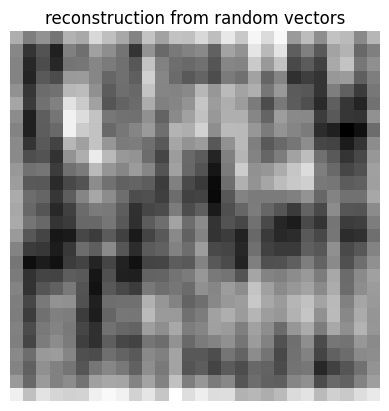

In [33]:
# Trying with random vectors
query = torch.zeros((1, bottleneck_size))
# query = torch.ones((1, bottleneck_size))

# Observing the reconstructed image
reconstructed_img, latent = autoencoder(query, inference=True)
plt.imshow(reconstructed_img.squeeze().detach().numpy(), cmap='gray')
plt.title(f"reconstruction from random vectors")
plt.axis('off')

plt.savefig(f"logs/reconstruction_from_random_vectors.png")
plt.show()
plt.close()